In [1]:
from jax import numpy as jnp
from jax import random, jit
from optax import adam, sgd
from einops import rearrange
import equinox as eqx
from jax.random import split
from jax.tree_util import tree_map
import copy
import matplotlib.pyplot as plt
import matplotlib

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 3)
TRAIN_KEY = random.PRNGKey(SEED + 2)
EX_TEST_KEY = random.PRNGKey(SEED + 9)
EX_TRAIN_KEY = random.PRNGKey(SEED + 4)

# Matplotlib settings
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
font = {'size'   : 12}

matplotlib.rc('font', **font)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
from loss import multi_batch_loss, multi_batch_loss_fomaml, batch_loss

from loops import step, train_loop
from loops import outer_step_METASGD, inner_step_METASGD
from loops import outer_step_MAML, inner_step_MAML
from loops import outer_step_FOMAML, inner_step_FOMAML
from loops import outer_step_REPTILE, inner_step_REPTILE

from dataloader import load_batch_of_tasks, load_task
from plot import info_meta_test, disp_meta_test
from evaluate import evaluation

In [3]:
# Inital parameters
epochs = 60000
meta_batch_size = 4 
n_train = 5  # shot training 
n_test = 10  # shot testing 
n_meta_test = 100  # meta evaluation points 
test_keys = random.split(TEST_KEY, epochs)
train_keys = random.split(TRAIN_KEY, epochs)
t_score = 1.9842169515086827 # T-distribution 95% confidence for 100 runs

In [4]:
# META SGD
model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
alpha = copy.deepcopy(eqx.filter(model,eqx.is_array))
init_const = 0.05  # should be between 0.005 and 0.1
alpha = tree_map(lambda x: init_const*jnp.ones(shape=x.shape), alpha)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter((model,alpha), eqx.is_array))  
inner_optim = sgd(1) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

In [5]:
model, alpha = train_loop((model,alpha),epochs,n_train, n_test,train_keys,test_keys,
                           meta_batch_size,batch_loss,outer_step_METASGD,outer_optim,
                           outer_opt_state,inner_step_METASGD,inner_optim,inner_opt_state)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [6]:
mean, std = evaluation((model, alpha), n_train, n_meta_test, TRAIN_KEY, TEST_KEY, inner_step_METASGD, inner_optim, inner_opt_state, batch_loss)
print(f"Mean {mean:.3}, 95% Error {t_score*std/jnp.sqrt(n_meta_test):.3}")

Mean 0.463, 95% Error 0.0778


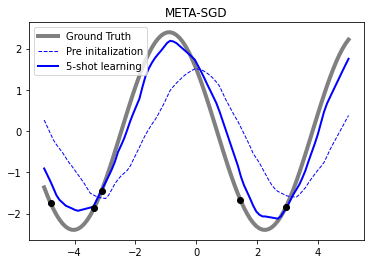

0.16718544


In [7]:
mse, pre_init_plt_metasgd, gt_plt, kshot_plt_metasgd, scatter_points = info_meta_test(model,(model, alpha), n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_METASGD, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_metasgd], gt_plt, [kshot_plt_metasgd], scatter_points, n_train, title="META-SGD")
print(mse)

In [8]:
# MAML

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array))  
inner_optim = sgd(0.01) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))


In [9]:
model = train_loop(model,epochs,n_train, n_test,train_keys,test_keys,
                           meta_batch_size,batch_loss,outer_step_MAML,outer_optim,
                           outer_opt_state,inner_step_MAML,inner_optim,inner_opt_state)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [10]:
mean, std = evaluation(model, n_train, n_meta_test, TRAIN_KEY, TEST_KEY, inner_step_MAML, inner_optim, inner_opt_state, batch_loss)
print(f"Mean {mean:.3}, 95% Error {t_score*std/jnp.sqrt(n_meta_test):.3}")

Mean 0.718, 95% Error 0.126


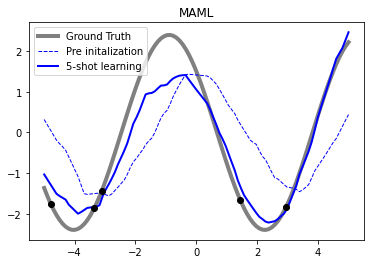

Array(0.26372305, dtype=float32)

In [11]:
mse, pre_init_plt_maml, gt_plt, kshot_plt_maml, scatter_points = info_meta_test(model, model, n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_MAML, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_maml], gt_plt, [kshot_plt_maml], scatter_points, n_train, title="MAML")
mse

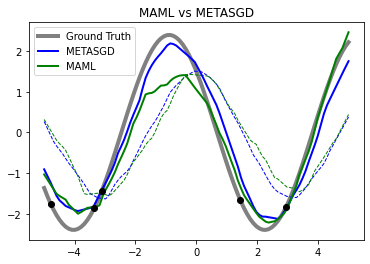

In [12]:
# plot META-SGD and MAML together 
disp_meta_test([pre_init_plt_metasgd, pre_init_plt_maml], gt_plt, [kshot_plt_metasgd, kshot_plt_maml],
               scatter_points, n_train, legends=['METASGD', 'MAML'], title="MAML vs METASGD")

In [13]:
# FOMAML

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array)) 
inner_optim = sgd(0.01) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

In [14]:
model = train_loop(model,epochs,n_train, n_test,train_keys,test_keys,
                           meta_batch_size,batch_loss,outer_step_FOMAML,outer_optim,
                           outer_opt_state,inner_step_FOMAML,inner_optim,inner_opt_state)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [15]:
mean, std = evaluation(model, n_train, n_meta_test, TRAIN_KEY, 
                   TEST_KEY, inner_step_FOMAML, inner_optim, inner_opt_state, batch_loss)
print(f"Mean {mean:.3}, 95% Error {t_score*std/jnp.sqrt(n_meta_test):.3}")

Mean 0.763, 95% Error 0.139


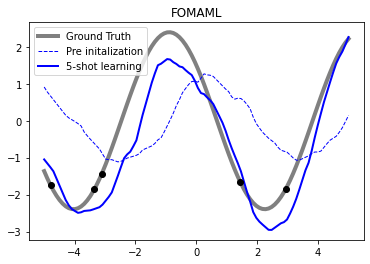

Array(0.51068455, dtype=float32)

In [16]:
mse, pre_init_plt_fomaml, gt_plt, kshot_plt_fomaml, scatter_points = info_meta_test(model, model, n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_FOMAML, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_fomaml], gt_plt, [kshot_plt_fomaml], scatter_points, n_train, title="FOMAML")
mse

In [17]:
# REPTILE
epochs = 60000

model = eqx.nn.MLP(1,1,64,2,key=MODEL_KEY)
outer_optim = None
outer_opt_state = None
inner_optim = adam(1e-3) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))
epsilon = 0.01
n_steps = 32

In [18]:
model =  train_loop(model,epochs,n_train, n_test,train_keys,test_keys,
                           meta_batch_size,batch_loss,outer_step_REPTILE,outer_optim,
                           outer_opt_state,inner_step_REPTILE,inner_optim,inner_opt_state,epsilon=epsilon,n_steps=n_steps)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [19]:
mean, std = evaluation(model, n_train, n_meta_test, TRAIN_KEY, TEST_KEY, 
                       inner_step_REPTILE, inner_optim, inner_opt_state, batch_loss,n_steps=n_steps)
print(f"Mean {mean:.3}, 95% Error {t_score*std/jnp.sqrt(n_meta_test):.3}")

Mean 2.46, 95% Error 0.525


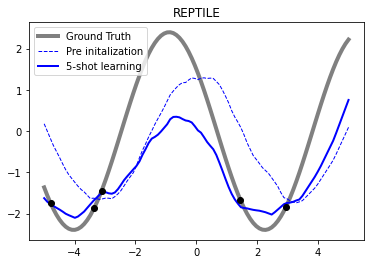

Array(1.4477602, dtype=float32)

In [20]:
mse, pre_init_plt_reptile, gt_plt, kshot_plt_reptile, scatter_points = info_meta_test(model, model, n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_REPTILE, inner_optim, inner_opt_state, 
                                                                      batch_loss,n_steps=n_steps)
disp_meta_test([pre_init_plt_reptile], gt_plt, [kshot_plt_reptile], scatter_points, n_train, title="REPTILE")
mse